# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [181]:
# Load pickled data
import pickle
from sklearn.model_selection import train_test_split

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train, sizes_train, coords_train = (train['features'], 
            train['labels'], train['sizes'], train['coords'])
X_test, y_test, sizes_test, coords_test = (test['features'], 
            test['labels'], test['sizes'], test['coords'])

#Load CSV for key/label mappings
import csv
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    labels_list = list(map(tuple, reader))
    #remove first tuple which is only a header
    labels_list = labels_list[1:]

#split training into train + validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [182]:
#Step 0 Testing Block

print(labels_list[1][1])
print(train['sizes'][3], X_train[3].shape, coords_train[1])

Speed limit (30km/h)
[31 31] (32, 32, 3) [ 5  5 25 25]


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [183]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# Number of validation examples
n_val = len(X_val)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = y_train.max()

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_val)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 31367
Number of testing examples = 12630
Number of validation examples = 7842
Image data shape = (32, 32, 3)
Number of classes = 42


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

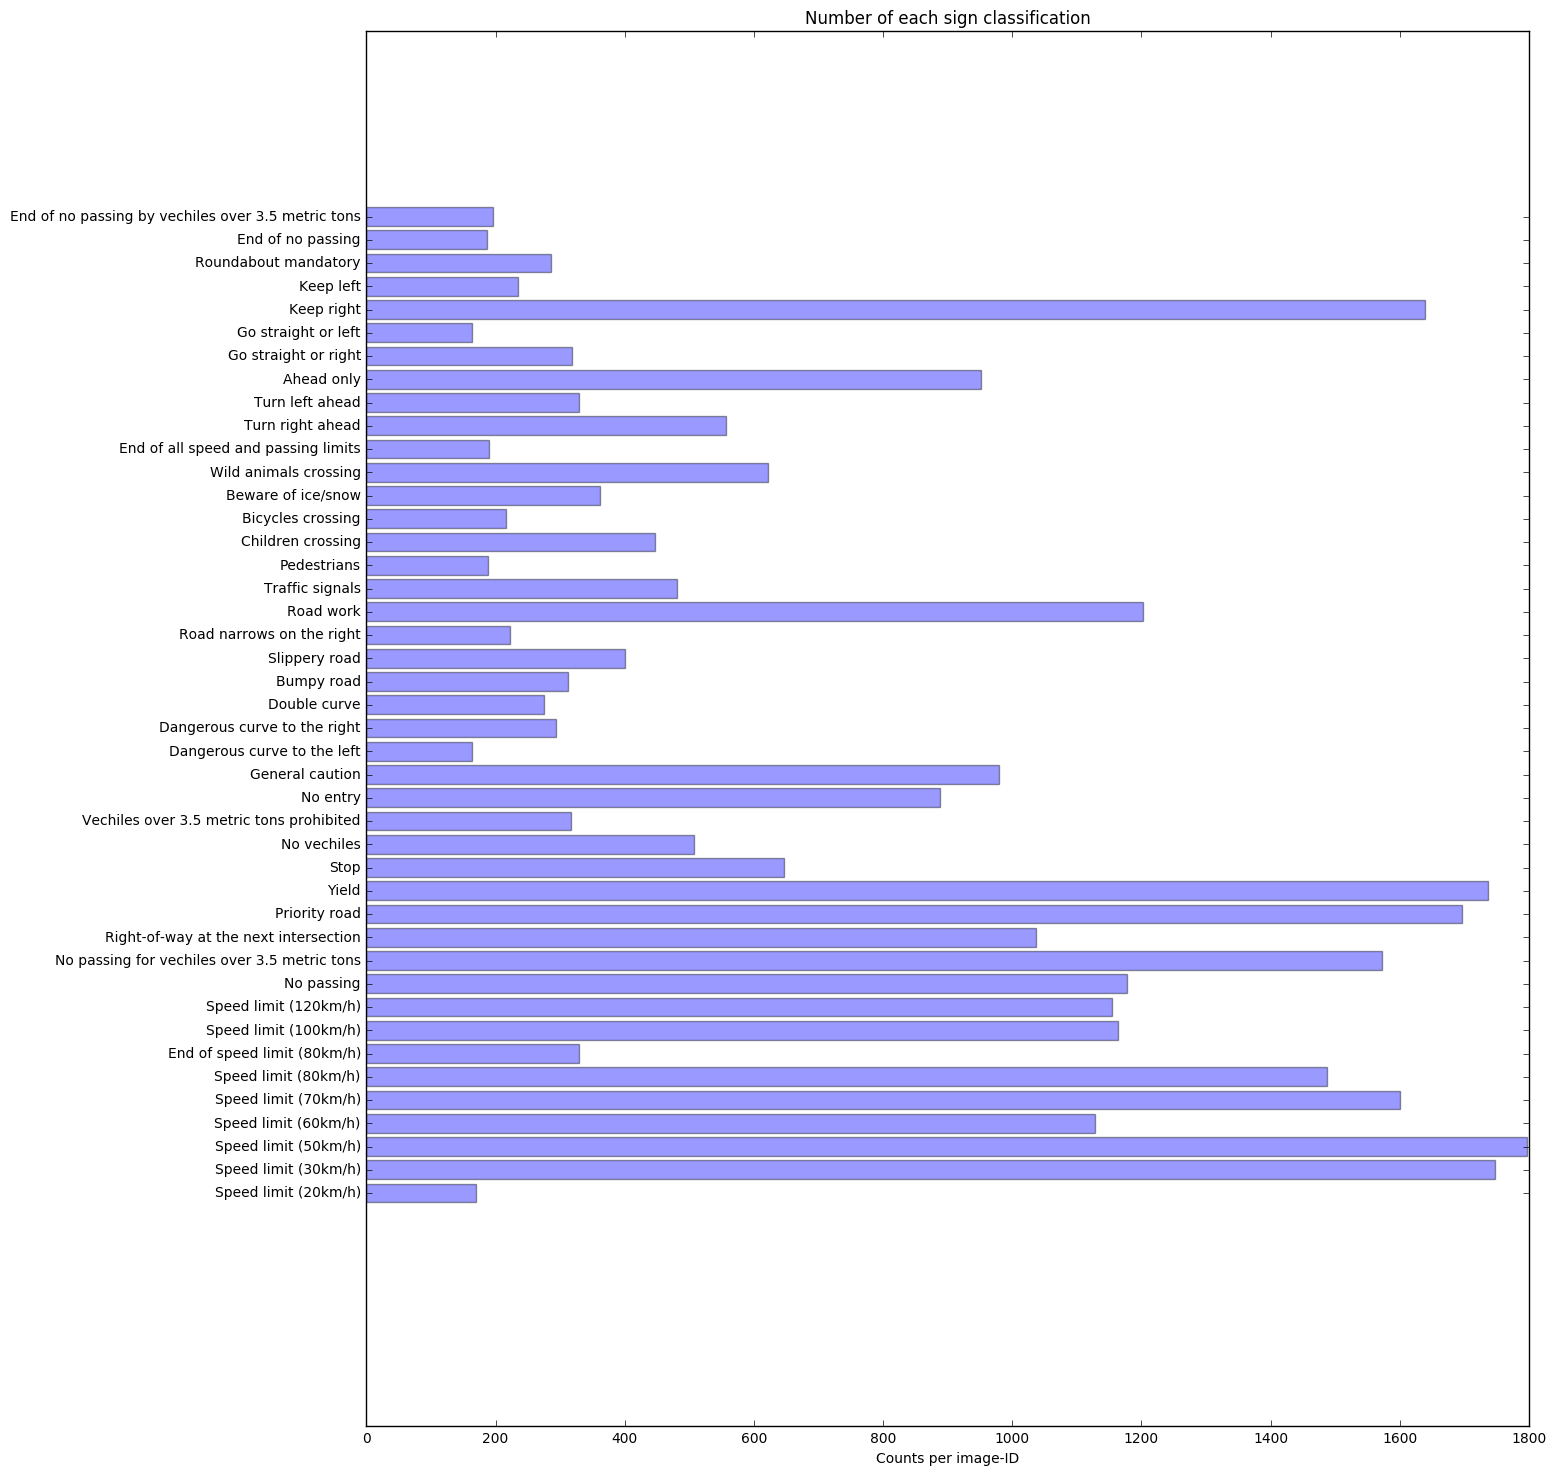

In [184]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt
import numpy as np
import collections
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.rcParams["figure.figsize"] = (15.0, 18.0)

# Create a collection
data = collections.Counter(y_train)

keys = data.keys()
y_pos = np.arange(len(keys))

# get the counts for each key, assuming the values are numerical
signCounts = [data[k] for k in keys]

#map label numbers to values in CSV
yLabels = [labels_list[y][1] for y in y_pos]

#BarH plots count of each sign
plt.barh(y_pos, signCounts, align='center', alpha=0.4)
plt.yticks(y_pos, yLabels)
plt.xlabel('Counts per image-ID')
plt.title('Number of each sign classification')

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [185]:
from scipy.misc import imresize
%matplotlib inline

#crops a numpy of raw images
def crop(x):
    index = 0
    y = []
    for img in x:
        #crop images to sign bounding box
        #adjust crop coords for the resize of images
        origX = sizes_train[index][0]
        origY = sizes_train[index][1]
        x1 = coords_train[index][0]
        y1 = coords_train[index][1]
        x2 = coords_train[index][2]
        y2 = coords_train[index][3]
        x1c = (x1/origX)*32
        y1c = (y1/origY)*32
        x2c = (x2/origX)*32
        y2c = (y2/origY)*32

        img = img[x1c:x2c, y1c:y2c]
        
        #RESIZE to 48x48
        img = imresize(img,(48,48))
        y.append(img)

        index = index+1
    return y

X_train = crop(X_train)
X_test = crop(X_test)
X_val = crop(X_val)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [186]:
# Test displays
#for i in range(10):
#    plt.figure(figsize=(1,1))
#    plt.imshow(X_train[i])

In [187]:
#Greyscale and visualize

#Greyscale
X_train = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_train], dtype=np.float32)
X_test = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_test], dtype=np.float32)
X_val = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_val], dtype=np.float32)

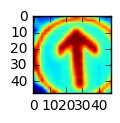

In [188]:
#Test check Grayscale image
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
#plt.imshow(image, cmap="gray")
plt.imshow(image)

In [189]:
#Normalization
import cv2

#Normalize
def normalize(image): 
    return cv2.normalize(image, None, 0.0, 1.0, cv2.NORM_MINMAX)
X_train = np.array([normalize(image) for image in X_train], dtype=np.float32)
X_test = np.array([normalize(image) for image in X_test], dtype=np.float32)
X_val = np.array([normalize(image) for image in X_val], dtype=np.float32)

#add depth channel
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_val = np.expand_dims(X_val, axis=3)

In [190]:
#Shuffle
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
X_val, y_val = shuffle(X_val, y_val)

# Test data cohesion
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))
assert(len(X_val) == len(y_val))

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(type(X_train))

(31367, 48, 48, 1)
(12630, 48, 48, 1)
(7842, 48, 48, 1)
<class 'numpy.ndarray'>


## Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** First I reshaped the data from 2D into 4D as the conv2d layers need a batch and channel dimension.
Next, I am padding the data with the matrix with 2 rows and 2 columns of zero this is to allow the output shape of
my first layer to easily be the same as the input.

In [191]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** I chose to take 10% of my training data and save it for validation. Since the initial import already split the feature and label into balanced sets I needed to grab a random balanced sample from these two. I used the initial arrays with the sklearn train_test_split function before preprocessing the data into tensors to achieve this.

In [192]:
from tensorflow.contrib.layers import flatten

EPOCHS = 10
BATCH_SIZE = 128

In [193]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
#I/O formula (in - out + 2*pad)/S + 1

import tensorflow as tf
# INPUT -> CONV -> ACT -> POOL -> CONV -> ACT -> POOL -> FLATTEN -> FC -> ACT -> FC
def goNet(x):
    #Hyperparameters
    mu = 0
    sigma = 0.1
    
    #in 48x48x1 out 42x42x100
    conv1_W = tf.Variable(tf.truncated_normal(shape=(7,7,1,100), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(100))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    #ACTIVATION
    conv1 = tf.nn.relu(conv1)

    #in 42x42x100 out 21x21x100
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #in 21x21x100 out 18x18x150
    conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 100, 150), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(150))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    #ACTIVATION
    conv2 = tf.nn.relu(conv2)

    #in 18x18x150 out 9x9x150
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #in 9x9x150 out 6x6x250
    conv3_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 150, 250), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(250))
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    #ACTIVATION
    conv3 = tf.nn.relu(conv3)
    
    #in 6x6x250 out 3x3x250
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    fc1 = flatten(conv3)
    fc1_shape = (fc1.get_shape().as_list()[-1], 300)

    #in 2250 out 300
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(300))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
 
    """ #in 120 out 84
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    """
    #in 300 out 42
    fc3_W = tf.Variable(tf.truncated_normal(shape=(300, 42), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(42))
    logits = tf.matmul(fc1, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [194]:
#Features and Labels

# 32x32x1 after padding
x = tf.placeholder(tf.float32, (None,48,48,1))
# Classify over 10 digits 0-6
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,42)

In [195]:
#Training Pipeline
rate = 0.001

logits = goNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation) 

In [196]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [200]:
from sklearn.metrics import f1_score

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
       
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_val, y_val)
        #print("f1_score", f1_score(logits, y_train))
        print(cross_entropy.Print())
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...



AttributeError: 'Tensor' object has no attribute 'Print'

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.